# Topic Modeling (LDA) on Japanese Text

## 0. Install libraries

In [32]:
!pip install mojimoji
!pip install MeCab

## 1. Reading in Japanese news corpus

In [54]:
import pandas as pd
import re
from collections import Counter, OrderedDict, defaultdict
import MeCab
import mojimoji

In [49]:
# news corpus gained from: https://nxdataka.netlify.app/ldncsv/
df = pd.read_csv("./livedoornews.csv")

In [51]:
df.shape

(7367, 5)

In [50]:
df

,url,datetime,title,body,media
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...,movie-enter
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」\n2月28日、映画『おかえり、はやぶさ』（3月...,movie-enter
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...,movie-enter
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...,movie-enter
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...,movie-enter
...,...,...,...,...,...
7362,http://news.livedoor.com/article/detail/6530260/,2012-05-05T09:55:00+0900,好きな戦士を作ってドラゴンボールの世界で天下一武道会優勝だ！「挑戦！天下一武道会」【Andr...,どんな戦士を作るかはユーザー次第！\n国民的人気を誇る鳥山明氏のマンガ／アニメである「DRA...,smax
7363,http://news.livedoor.com/article/detail/6681611/,2012-06-21T20:55:00+0900,NTTドコモ、GALAXY SIII SC-06DとF-09D ANTEPRIMAの発売日を...,GALAXY SIIIが6月28日、F-09D ANTEPRIMAが6月27日に発売！\nN...,smax
7364,http://news.livedoor.com/article/detail/6856578/,2012-08-15T11:55:00+0900,NTTドコモ、Android向け「docomo Wi-Fiかんたん接続アプリ」をバージョンア...,shimajiro@mobiler\nNTTドコモは、同社の公衆無線LANサービス「doco...,smax
7365,http://news.livedoor.com/article/detail/6678539/,2012-06-21T06:55:00+0900,NTTドコモ、PRADA Phone by LG L-02Dのデコメ絵文字popが正常に表示...,PRADA Phone by LG L-02Dにソフトウェア更新！\nNTTドコモは20日、...,smax


## 2. Preprocess text (Tokenization + POS tagging)

In [42]:
#MeCabを使った処理のためのクラス
class MeCabHandler:
    def __init__(self, tagger):
        self._handler = tagger

    def surface(self, text):
        self._handler.parse("")
        result = self._handler.parseToNode(text)
        filtered_words = []
        while result:
            filtered_words.append(result.surface)
            result = result.next

        return filtered_words

    def pos(self, text):
        self._handler.parse("")
        result = self._handler.parseToNode(text)
        pos = []
        while result:
            features = result.feature.split(',')
            pos.append(features[0])
            result = result.next

        return pos


#前処理用の関数
def preprocess(text):
    text = text.lower()
    text = mojimoji.zen_to_han(text, kana=False)
    text = mojimoji.han_to_zen(text, digit=False, ascii=False)
    text = text.translate(str.maketrans({
        '!': '！', '"': '”', '#': '＃', '$': '＄', '%': '％', '&': '＆', '\'': '’',
        '(': '（', ')': '）', '*': '＊', '+': '＋', ',': '，', '-': '−', '.': '．',
        '/': '／', ':': '：', ';': '；', '<': '＜', '=': '＝', '>': '＞', '?': '？',
        '@': '＠', '[': '［', '\\': '＼', ']': '］', '^': '＾', '_': '＿', '`': '｀',
        '{': '｛', '|': '｜', '}': '｝'
        }))
    zenkaku_leftsingle = b'\xe2\x80\x98'.decode('utf-8')
    text = re.sub('[’´｀]', zenkaku_leftsingle, text)
    return text


#文字コードを確認する関数
def getEncode(filepath):
    encs = "iso-2022-jp euc-jp shift_jis utf-8".split()
    for enc in encs:
        with open(filepath, encoding=enc) as fr:
            try:
                fr = fr.read()
            except UnicodeDecodeError:
                continue
        return enc


In [85]:
def preprocessDf(filename):
    """Reads in Japanese news dataframe from filename, and returns a corpus of the body text tokenized,
    as well as part-of-speech (pos) tags for them."""
    # read in and define dependencies
    mt = MeCab.Tagger("-Ochasen -u " + "user_dict.dic")
    handler = MeCabHandler(mt)
    enc = getEncode(FILENAME)
    df = pd.read_csv(FILENAME, encoding=enc)
    preprocessedRow = OrderedDict()
    outDf = pd.DataFrame()
    
    for i, row in df.iterrows():
        
        url = row["url"]
        datetime = row["datetime"]
        title = row["title"]
        body = row["body"]
        media = row["media"]
        
        # preprocess text
        filteredText = preprocess(body)
        tokenizedText = " ".join(handler.surface(filteredText)[1:-1])
        
        preprocessedRow["url"] = url
        preprocessedRow["datetime"] = datetime
        preprocessedRow["body"] = tokenizedText
        
        # calculate pos rate
        computePosRate(handler, tokenizedText, preprocessedRow)
        
        # Append to Dataframe
        outDf = outDf.append(pd.DataFrame(preprocessedRow, index=[i]))
        
    return outDf

def computePosRate(handler, text, preprocessedRow):
    # Calculate pos_rate
    pos = handler.pos(text)[1:-1]

    cnt = Counter(pos).most_common()
    wc = len(pos)
    preprocessedRow["WC"] = wc
    for tpl in cnt:
        preprocessedRow[tpl[0]] = '{:.2f}'.format((tpl[1] / wc)*100)
        
    return

In [87]:
# define filename for input corpus
FILENAME = './livedoornews.csv'

In [90]:
preprocessedDf = preprocessDf(FILENAME)
preprocessedDf.to_csv("./preprocessed_corpus.csv")

In [89]:
preprocessedDf

,url,datetime,body,WC,名詞,助詞,記号,動詞,助動詞,副詞,連体詞,接頭詞,接続詞,形容詞,感動詞,フィラー,その他
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,2005 年 11 月 から 翌 2006 年 7 月 まで 読売新聞 にて 連載 さ れ ...,800,42.12,23.62,12.00,11.88,8.12,0.88,0.50,0.38,0.25,0.25,NaN,NaN,NaN
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,「 アンテナ を 張り ながら 生活 を し て いけ ば いい 」 2 月 28 日 、 ...,1264,34.18,26.66,12.66,13.13,8.86,1.98,0.55,0.47,0.08,0.87,0.40,0.16,NaN
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,3 月 2 日 より 全国 ロードショー と なる 、 スティーブン ・ スピルバーグ の ...,1267,38.20,26.52,12.47,11.92,5.29,1.03,1.34,0.95,0.47,1.82,0.40,0.16,NaN
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,女優 の 香里奈 が 18 日 、 都内 で 行わ れ た 映画 『 ガール 』 （ 5 月...,600,29.67,26.00,19.17,12.50,7.50,1.67,0.50,0.67,0.67,1.33,0.33,0.16,NaN
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,5 日 、 東京 ・ 千代田 区 の 内幸町 ホール にて 、 映画 『 キャプテン ・ ア...,1149,33.77,25.76,15.67,10.53,10.18,1.48,0.70,0.26,0.78,0.87,0.33,0.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7362,http://news.livedoor.com/article/detail/6530260/,2012-05-05T09:55:00+0900,どんな 戦士 を 作る か は ユーザー 次第 ！ 国民 的 人気 を 誇る 鳥山 明 氏 ...,793,37.58,24.34,14.25,11.98,7.82,0.63,0.38,0.13,0.76,2.02,0.15,0.13,0.21
7363,http://news.livedoor.com/article/detail/6681611/,2012-06-21T20:55:00+0900,galaxy siii が 6 月 28 日 、 f − 09 d anteprima が ...,293,61.09,10.24,22.53,3.07,2.39,0.63,0.38,0.34,0.76,0.34,0.15,0.13,0.21
7364,http://news.livedoor.com/article/detail/6856578/,2012-08-15T11:55:00+0900,shimajiro ＠ mobiler ntt ドコモ は 、 同社 の 公衆 無線 lan...,1066,49.34,21.48,16.89,7.04,2.63,0.66,0.38,0.56,0.09,0.94,0.15,0.13,0.21
7365,http://news.livedoor.com/article/detail/6678539/,2012-06-21T06:55:00+0900,prada phone by lg l − 02 d に ソフトウェア 更新 ！ ntt ド...,982,45.01,18.43,17.01,11.10,5.91,0.51,0.20,0.51,0.51,0.81,0.15,0.13,0.21


## 3. Perform LDA on corpus

In [91]:
# Read preprocessed corpus
df = pd.read_csv("./preprocessed_corpus.csv")

In [92]:
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:
        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')

        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words

## Adding Stopwords

In [93]:
import urllib

req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')

with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')

while '' in stopwords:
    stopwords.remove('')

print(stopwords)

['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', 'ハイ', '上', '中', '下', '字', '年', '月', '日', '時', '分', '秒', '週', '火', '水', '木', '金', '土', '国', '都', '道', '府', '県', '市', '区', '町', '村', '各', '第', '方', '何', '的', '度', '文', '者', '性', '体', '人', '他', '今', '部', '課', '係', '外', '類', '達', '気', '室', '口', '誰', '用', '界', '会', '首', '男', '女', '別', '話', '私', '屋', '店', '家', '場', '等', '見', '際', '観', '段', '

In [94]:
sample_text = df["body"][0]

mecab = MeCab.Tagger("-Ochasen -u" + "user_dict.dic")
words = analyzer(sample_text, mecab, stopwords=stopwords, target_part_of_speech=["noun", "proper_noun"])

In [96]:
# Uncomment the following to see nouns and proper nouns of the first news article in dataset

# words

### Use gensim and the analyzer previously created in order to create a dictionary of word ids and a bag-of-words corpus

In [98]:
import gensim

mecab = MeCab.Tagger("-Ochasen -u" + "user_dict.dic")

import time

t0 = time.time()

texts = []
for text in df["body"]:
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=["noun", "proper_noun"])
    texts.append(words)

dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.8)
corpus = [dictionary.doc2bow(t) for t in texts]

# LDA
num_topics = 20
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

print("finished in " + str(time.time() - t0) + "s")

finished in 19.277762174606323s


In [99]:
print("vocab size: ", len(dictionary))

vocab size:  17528


## 4. Visualize Output

In [101]:
import numpy as np
import math
from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pylab as plt

np.random.seed(0)
FONT = "/Library/Fonts/Arial Unicode.ttf"

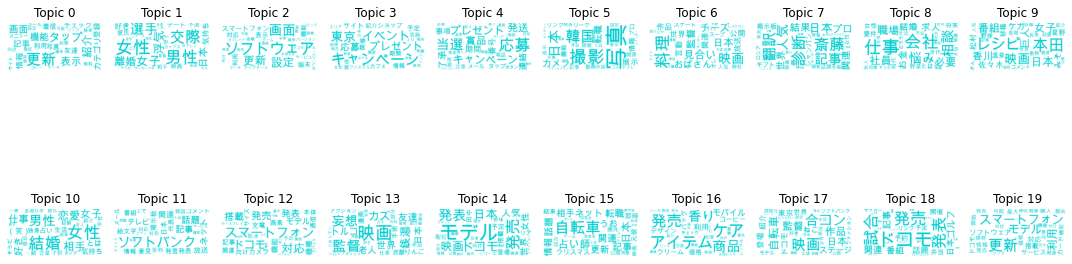

In [102]:
def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

# Visualize
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()



for i, t in enumerate(range(lda_model.num_topics)):
    
    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize_50cities.png")

The above cleanly shows the topics that are discussed among the 7000 news articles.

In [10]:
# text = open(text_paths[0], 'r').read()
text = 
text = text.split('\n')
title = text[2]
text = ' '.join(text[3:])

mecab = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])

print(title)
print(words)

NameError: name 'text_paths' is not defined

In [11]:
import gensim

mecab = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')

titles = []
texts = []
for text_path in text_paths:
    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
    texts.append(words)

dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.8)
corpus = [dictionary.doc2bow(t) for t in texts]

print('vocab size: ', len(dictionary)) # vocab size:  28824

RuntimeError: 
----------------------------------------------------------

Failed initializing MeCab. Please see the README for possible solutions:

    https://github.com/SamuraiT/mecab-python3#common-issues

If you are still having trouble, please file an issue here, and include the
ERROR DETAILS below:

    https://github.com/SamuraiT/mecab-python3/issues

issueを英語で書く必要はありません。

------------------- ERROR DETAILS ------------------------
arguments: -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd
[ifs] no such file or directory: /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/dicrc
----------------------------------------------------------


In [13]:
FILENAME = "./livedoornews.csv"

In [14]:
def preprocess_citydata():
    mt = MeCab.Tagger("-Ochasen -u " + "user_dict.dic")
    handler = MeCabHandler(mt)
    wakati = []
    pos = []
    
    enc = getEncode(FILENAME)
    df = pd.read_csv(FILENAME, encoding=enc)

    for txt in df["body"]:
        
        txt = str(txt)
        
        filtered_text = preprocess(txt)
        wakati.append(handler.surface(filtered_text)[1:-1])
        pos = handler.pos(filtered_text)[1:-1]
        
        cnt = Counter(pos).most_common()
        wc = len(pos)
        dic = OrderedDict()
#         dic['WC'] = wc
        dic['text'] = date
#         dic['city'] = city
        
        for tpl in cnt:
            dic[tpl[0]] = '{:.2f}'.format((tpl[1] / wc)*100)
        
    with open(OUTPUT_PATH, 'w', encoding='utf_8_sig') as w:
        writer = csv.writer(w, lineterminator='\n', delimiter=' ')
        writer.writerows(wakati)

    #品詞ファイル出力
    pd.DataFrame.from_dict(dic, orient='index').T.to_csv(POS_PATH, index=False, sep='\t')

In [15]:
preprocess_citydata()

RuntimeError: 
----------------------------------------------------------

Failed initializing MeCab. Please see the README for possible solutions:

    https://github.com/SamuraiT/mecab-python3#common-issues

If you are still having trouble, please file an issue here, and include the
ERROR DETAILS below:

    https://github.com/SamuraiT/mecab-python3/issues

issueを英語で書く必要はありません。

------------------- ERROR DETAILS ------------------------
arguments: -Ochasen -u user_dict.dic
) [tokenizer_->open(param)] tokenizer.cpp(127) [d->open(dicfile[i])] dictionary.cpp(79) [dmmap_->open(file, mode)] no such file or directory: user_dict.dic 
----------------------------------------------------------
